In [31]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
import re

import matplotlib.pyplot as plt

### Load Data

In [2]:
train = pd.read_csv("twitter_train.csv")
# print(train.shape) # 31962 x 3
train.head() # label: 1 = racist/sexist; 0 = not racist/sexist

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [5]:
# sample tweets from both labels
np.random.seed(22)
idx0 = np.where(train['label'] == 0)
idx1 = np.where(train['label'] == 1)
train['tweet'][np.random.choice(idx0[0],6)] # non-racist/sexist

11966    flaxseed gel/shampoo results!  #peace #love #o...
24368     @user great end to a great day! happy weekend...
31695    @user given what we now know, how the church s...
26812             happy day!  #altwaystoheal  #healthy    
23501    18 km in the rain along the thames. perfect st...
24759    #zaynmalik   bull up: you will dominate your b...
Name: tweet, dtype: object

In [6]:
train['tweet'][np.random.choice(idx1[0],6)] # racist/sexist

7085     happy new year white people elected a  preside...
14082    are you #black &amp; feel like the  are â¦on ...
24026    @user after 8 yrs of endless lies, contempt fr...
22285    thought factory: left-right polarisation! #tru...
10852    @user #allahsoil not all muslims hate america....
14530    trump is a cuck  @user #nazi #swastika #ebay! ...
Name: tweet, dtype: object

### Format, Sample Data

In [7]:
def list_to_onehot(y, list_classes):
    """
    y = list of class lables of length n
    output = n x k array, i th row = one-hot encoding of y[i] (e.g., [0,0,1,0,0])
    """
    Y = np.zeros(shape = [len(y), len(list_classes)], dtype=int)
    for i in np.arange(Y.shape[0]):
        for j in np.arange(len(list_classes)):
            if y[i] == list_classes[j]:
                Y[i,j] = 1
    return Y
def onehot_to_list(y, list_classes=None):
    """
    y = n x k array, i th row = one-hot encoding of y[i] (e.g., [0,0,1,0,0])
    output =  list of class lables of length n
    """
    if list_classes is None:
        list_classes = np.arange(y.shape[1])
        
    y_list = []
    for i in np.arange(y.shape[0]):
        idx = np.where(y[i,:]==1)
        idx = idx[0][0]
        y_list.append(list_classes[idx])
    return y_list

In [8]:
def sample_tweets(list_classes=[0, 1], categories=[0,1], train_size=0.8, min_df = 2, vectorizer = 'tf-idf', full_data=None,):
    """
    list_classes = one-hot labels for each class
    train_size = proportion of full_data to split to train
    min_df = minimum word frequency for vectorizer
    vectorizer = either count or tf-idf
    output = train and test X and Y, data_dict
    """
    
    # remove stopwords and numbers from tweets
    stopwords_list = stopwords.words('english')
    stopwords_list.extend(["’", "“", "”", "https", "co", "user", "amp", "get", "go", "one"]) # remove stopwords
    train = [re.sub(r'\d+','', tweet) for tweet in full_data.tweet] # remove numbers from tweets
    y = full_data.label # tweet class labels 
    Y = list_to_onehot(y.tolist(), list_classes)

    # set vectorizer
    # min-df = n; requires words to appear at least n times in corpus
    if vectorizer == 'tf-idf':
        vectorizer = TfidfVectorizer(stop_words=stopwords_list,min_df=2)
    else:
        vectorizer = CountVectorizer(stop_words=stopwords_list,min_df=2) 
    X = vectorizer.fit_transform(train) # convert to words x docs (word frequency)
    X = np.asarray(X.todense())
    print('X.shape:', X.shape)
    idx_to_word = np.array(vectorizer.get_feature_names())   # list of words that corresponds to feature coordinates

    # update data dict
    data_dict = {}
    data_dict.update({'categories': categories})
    data_dict.update({'train': train})
    data_dict.update({'tweet_labels': y})
    data_dict.update({'feature_matrix': X})
    data_dict.update({'idx_to_word': idx_to_word})

    # train-test split
    X_train = []
    X_test = []
    y_test = []
    y_train = []

    for i in np.arange(X.shape[0]):
        # for each example i, make it into train set with probabiliy 0.8 and into test set otherwise 
        U = np.random.rand() # Uniform([0,1]) variable
        if U < train_size:
            X_train.append(X[i,:])
            y_train.append(Y[i,:].copy())
        else:
            X_test.append(X[i,:])
            y_test.append(Y[i,:].copy())

    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)
    
    data_dict.update({'X_train': X_train})
    data_dict.update({'X_test': X_test})
    data_dict.update({'y_train': y_train})
    data_dict.update({'y_test': y_test})
  
    return X_train, X_test, y_train, y_test, data_dict 

categories = ['non-racist/sexist','racist/sexist'] 

# fit with tf-idf vectorizer
X_train, X_test, y_train, y_test, data_dict = sample_tweets(list_classes=[0, 1],
                                                            categories = categories,
                                                            train_size = 0.8,
                                                            min_df = 2,
                                                            vectorizer = 'tf-idf',
#                                                             vectorizer='Count',
                                                            full_data=train)
print('X_train.shape:', X_train.shape)
print('X_test.shape:', X_test.shape)
print('y_train.shape:', y_train.shape)
print('y_test.shape:', y_test.shape)
print('y_test\n', y_test)
print('y_list\n', onehot_to_list(y_test)[:6])
print('idx_to_word\n', data_dict['idx_to_word'])

X.shape: (31962, 14896)
X_train.shape: (25557, 14896)
X_test.shape: (6405, 14896)
y_train.shape: (25557, 2)
y_test.shape: (6405, 2)
y_test
 [[1 0]
 [1 0]
 [1 0]
 ...
 [1 0]
 [1 0]
 [1 0]]
y_list
 [0, 0, 0, 0, 0, 0]
idx_to_word
 ['_animaladvocate' '_pearls' '_ë³' ... 'ð¾ñ' 'ó¾' 'ø¹ù']


### Check most frequent words for other stopwords to remove
- found: "user", "amp", "get", "go", "one"

In [9]:
idx_to_word = data_dict['idx_to_word']
sums = np.sum(X_train,axis=0)
word_freq = pd.DataFrame(data={'word': idx_to_word, 'frequency (tf-idf)': sums})

In [10]:
word_freq.sort_values(by=['frequency (tf-idf)'],ascending=False)[:20]

,word,frequency (tf-idf)
7817,love,463.009222
3232,day,411.911274
5841,happy,296.794766
13243,time,266.132583
13056,thankful,263.900414
10083,positive,238.902671
7578,life,215.521863
13289,today,213.846621
1290,bihday,202.587755
8918,new,188.792559


In [ ]:
# word cloud for different labels
def plot_wordcloud(Y, H, idx_to_word, categories):
        # plot the class-conditioanl PMF as wordclouds 
        # Y = (n x k), H = (p x n) (\Phi in lecture note), W = (p x k)
        # idx_to_word = list of words used in the vectorization of documents 
        # categories = list of class labels
        # prior on class labels = empirical PMF = [ # class i examples / total ]
        # class-conditional for class i = [ # word j in class i examples / # words in class i examples]
        
        class_conditional_PMF = []
        for i in np.arange(Y.shape[1]):
            idx = np.where(Y[:,i]==1)
            sub_H = H[:,idx[0]]
            word_count_per_class = np.sum(sub_H, axis=1)
            class_conditional_PMF.append(word_count_per_class/np.sum(word_count_per_class))
    
        ### topic mode
        num_words_to_sample = 10000
        
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 7), subplot_kw={'xticks': [], 'yticks': []})
        for ax, i in zip(axs.flat, np.arange(Y.shape[0])):
            dist = class_conditional_PMF[i]

            # sample (num_words_to_sample) proportionate to CC_PMF
            list_words = []
        
            for j in range(num_words_to_sample):
                idx = np.random.choice(np.arange(H.shape[0]), p=dist)
                list_words.append(idx_to_word[idx])
                
            Y = " ".join(list_words) # list to string
#             print(Y)
            STOPWORDS.update(["’", "“", "”", "https", "co", "user", "amp", "get", "go", "one"])
            wordcloud = WordCloud(background_color="black",
                                  relative_scaling=0.1,
                                  width=400,
                                  height=400).generate(Y)
            ax.imshow(wordcloud, interpolation='bilinear')
            ax.set_xlabel(categories[i], fontsize='20')
            # ax.axis("off")

        plt.tight_layout()
        plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.08)
        plt.savefig('wordcloud_tf-idf_twitter.pdf', bbox_inches='tight')

plot_wordcloud(Y=np.asarray(y_train), H=X_train.T, idx_to_word=idx_to_word, categories=categories)

## Naive Bayes Classifier

In [11]:
def fit_NB(Y, H,pseudocount = 10**-5):
    '''
    Fit Multinomial Naive Bayes Calssifier
    Use the Maximum Likelihood prior and class conditional probabilities (in closed forms)
    Y = (n x k), H = (p x n) (\Phi in lecture note), W = (p x k)
    prior on class labels = empirical PMF = [ # class i examples / total ]
    class-conditional for class i = [ # word j in class i examples / # words in class i examples]
    Output = prior (k, ), class_conditional_PMF = (k, p)
    '''
    k = Y.shape[1] # number of classes (2)

    prior = np.sum(Y, axis=0)/np.sum(np.sum(Y, axis=0))
#     print(prior)

    class_conditional_PMF = []
    for i in np.arange(Y.shape[1]):
        idx = np.where(Y[:,i]==1) # select indices with class 0 or 1
        # sub_H: documents with matching class
        sub_H = H[:,idx[0]] + pseudocount # add psuedocount
        word_count_per_class = np.sum(sub_H, axis=1)
        class_conditional_PMF.append(word_count_per_class/np.sum(word_count_per_class))

    return prior, np.asarray(class_conditional_PMF)

# find prior and class_conditional of train data 
prior, class_conditional_PMF = fit_NB(Y=y_train, H=X_train.T)
print(prior)
print(class_conditional_PMF)

[0.92976484 0.07023516]
[[1.65293073e-05 1.49876748e-05 1.11397453e-05 ... 8.18972305e-06
  8.20334232e-04 1.14201273e-05]
 [3.74611132e-06 3.74611132e-06 3.74611132e-06 ... 3.74611132e-06
  3.74611132e-06 1.05507741e-04]]


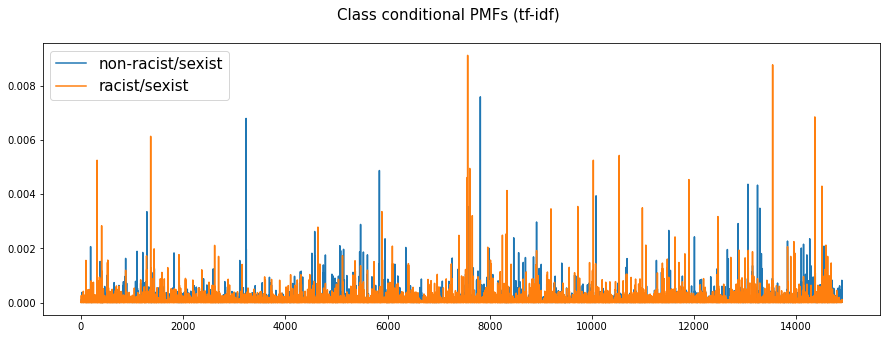

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 5])
for i in [0,1]:
    ax.plot(np.arange(X_train.shape[1]), class_conditional_PMF[i], label=categories[i])
ax.legend(fontsize='15')
plt.suptitle("Class conditional PMFs (tf-idf)", fontsize='15')
plt.savefig('PMF_dist_tf-idf_twitter.pdf', bbox_inches='tight')

(6405, 14896)
(2, 14896)
[[9.98711635e-01 1.28836530e-03]
 [9.98508833e-01 1.49116683e-03]
 [9.99997654e-01 2.34624389e-06]
 [9.99507980e-01 4.92020083e-04]
 [9.96431050e-01 3.56895022e-03]
 [9.87865528e-01 1.21344723e-02]]


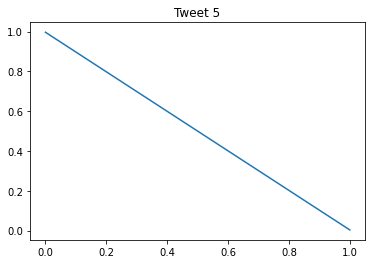

In [13]:
def predict_MNB(X_test, prior, class_conditional_PMF):
    '''
    Compute predicted PMF for the test data given prior and class_conditional_PMF
    Simple use of Bayes' Theorem 
    X_test = (p x n) (words x docs)
    '''
    print(X_test.shape)
    print(class_conditional_PMF.shape)
    
    P = class_conditional_PMF / np.min(class_conditional_PMF) # normalize so that log(P) is not too small 
    Q = np.exp(X_test @ np.log(P).T)
    Q = Q * np.repeat(prior[:, np.newaxis], repeats=Q.shape[0], axis=1).T
    sum_of_rows = Q.sum(axis=1)
    
    return Q / sum_of_rows[:, np.newaxis]

# find predictive PMF for X_test
predictive_PMF = predict_MNB(X_test, prior, class_conditional_PMF)
print(predictive_PMF[:6])
plt.title("Tweet 5")
plt.plot(predictive_PMF[4])

In [14]:
def compute_accuracy_metrics(Y_test, P_pred, use_opt_threshold=False, verbose=True):
    
    # y_test = binary label 
    # P_pred = predicted probability for y_test
    # compuate various binary classification accuracy metrics
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, P_pred, pos_label=None)
    mythre = thresholds[np.argmax(tpr - fpr)]
    myauc = metrics.auc(fpr, tpr)
    # print('!!! auc', myauc)
    
    # Compute classification statistics
    threshold = 0.5
    if use_opt_threshold:
        threshold = mythre
    
    Y_pred = P_pred.copy()
    Y_pred[Y_pred < threshold] = 0
    Y_pred[Y_pred >= threshold] = 1

    mcm = confusion_matrix(Y_test, Y_pred)
    
    tn = mcm[0, 0]
    tp = mcm[1, 1]
    fn = mcm[1, 0]
    fp = mcm[0, 1]

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tn / (tn + fp)
    specificity = tp / (tp + fn)
    precision = tp / (tp + fp)
    fall_out = fp / (fp + tn)
    miss_rate = fn / (fn + tp)

    # Save results
    results_dict = {}
    results_dict.update({'Y_test': Y_test})
    results_dict.update({'Y_pred': Y_pred})
    results_dict.update({'AUC': myauc})
    results_dict.update({'Opt_threshold': mythre})
    results_dict.update({'Accuracy': accuracy})
    results_dict.update({'Sensitivity': sensitivity})
    results_dict.update({'Specificity': specificity})
    results_dict.update({'Precision': precision})
    results_dict.update({'Fall_out': fall_out})
    results_dict.update({'Miss_rate': miss_rate})
    results_dict.update({'Confusion_mx': mcm})
    
    
    if verbose:
        for key in [key for key in results_dict.keys()]:
            if key not in ['Y_test', 'Y_pred', 'Confusion_mx']:
                print('% s ===> %.3f' % (key, results_dict.get(key)))
#         print('Confusion matrix \n ===>', mcm)
            
    return results_dict

### Compute Accuracy

In [15]:
result_dict_list = []
W_list = []
list_vectorizer = ['tf-idf']
for i in np.arange(len(list_vectorizer)):
    # compute metrics
    results_dict = compute_accuracy_metrics(Y_test=onehot_to_list(y_test), P_pred=predictive_PMF[:,1], verbose=True)
    result_dict_list.append(results_dict.copy())
    W_list.append(results_dict.get('Confusion_mx').copy())

    # scale W_list by count to format as proportion for confusion matrix
    true_counts = np.sum(W_list[0],axis=0)
    W_list2 = []
    conf_mat_prop = W_list[0] / true_counts
    print('Confusion Matrix ===>\n', conf_mat_prop)
    W_list2.append(conf_mat_prop)

AUC ===> 0.962
Opt_threshold ===> 0.042
Accuracy ===> 0.964
Sensitivity ===> 0.996
Specificity ===> 0.541
Precision ===> 0.913
Fall_out ===> 0.004
Miss_rate ===> 0.459
Confusion Matrix ===>
 [[0.96661238 0.08679245]
 [0.03338762 0.91320755]]


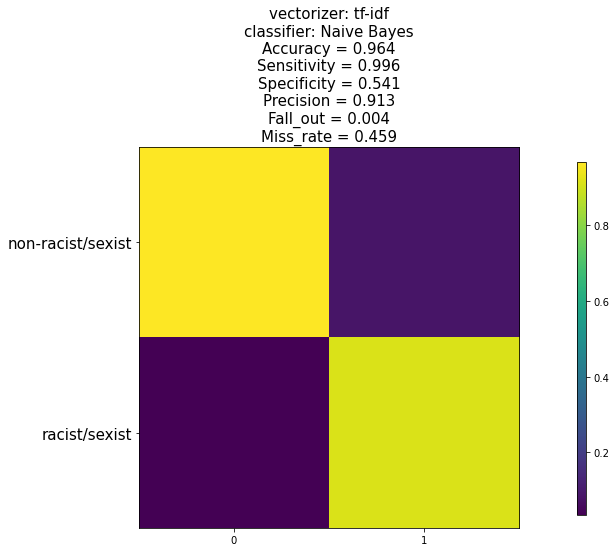

In [16]:
# make plot
fig, ax = plt.subplots(nrows=1, ncols=len(list_vectorizer), figsize=[12, 7])
class_labels= categories
for i in np.arange(len(list_vectorizer)):
    results_dict = result_dict_list[i]
    confusion_mx = results_dict.get('Confusion_mx')
    if len(list_vectorizer) > 1:
        confusion_mx = W_list2[i]
        im = ax[i].imshow(confusion_mx, vmin=np.min(W_list2), vmax=np.max(W_list2))
        ax[i].title.set_text("NB Confusion mx using %s vectorizer" % list_vectorizer[i])
        # ax[i].legend()
        # if i == len(list_digits) - 1:
        ax[i].set_xticks(np.arange(len(class_labels)))
        # ax[i].set_xticklabels(class_labels)
        ax[i].set_yticks(np.arange(len(class_labels)))
        ax[i].set_yticklabels(class_labels)
    else:
        confusion_mx = W_list2[i]
        im = ax.imshow(confusion_mx, vmin=np.min(W_list2), vmax=np.max(W_list2))
        ax.title.set_text("NB Confusion mx using %s vectorizer" % list_vectorizer[i])
        # ax[i].legend()
        # if i == len(list_digits) - 1:
        ax.set_xticks(np.arange(len(class_labels)))
        ax.set_yticks(np.arange(len(class_labels)))
        ax.set_yticklabels(class_labels, fontsize='15')
    
    subtitle = "vectorizer: " + str(list_vectorizer[i]) + "\n" + "classifier: " + str('Naive Bayes')
    keys_list = [i for i in results_dict.keys()]
    for key in keys_list:
        if key not in ['Y_test', 'Y_pred', 'AUC', 'Opt_threshold', 'Confusion_mx']:
            subtitle += "\n" + str(key) + " = " + str(np.round(results_dict.get(key),3))
            # print('%s = %f' % (key, results_list[i].get(key)))
    ax.set_title(subtitle, fontsize='15')
    
cbar_ax = fig.add_axes([0.8, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.savefig('confusion_mat_tf-idf_twitter.pdf', bbox_inches='tight')

## Logistic Regression

In [17]:
LR = LogisticRegression()
LR.fit(X_train, np.argmax(y_train,axis=1))

LogisticRegression()

### Predict and Compute Accuracy

In [18]:
LRpreds = LR.predict(X_test)

In [19]:
compute_accuracy_metrics(Y_test=np.argmax(y_test,axis=1), P_pred = LRpreds)

AUC ===> 0.645
Opt_threshold ===> 1.000
Accuracy ===> 0.949
Sensitivity ===> 0.999
Specificity ===> 0.291
Precision ===> 0.942
Fall_out ===> 0.001
Miss_rate ===> 0.709


{'Y_test': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'Y_pred': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'AUC': 0.6447425040158064,
 'Opt_threshold': 1,
 'Accuracy': 0.9492583918813428,
 'Sensitivity': 0.9986572675394427,
 'Specificity': 0.29082774049217003,
 'Precision': 0.9420289855072463,
 'Fall_out': 0.001342732460557234,
 'Miss_rate': 0.70917225950783,
 'Confusion_mx': array([[5950,    8],
        [ 317,  130]], dtype=int64)}

In [29]:
def fit_LR(stopwords_list, vectorizer=CountVectorizer, min_df = 0, train_size=0.8, penalty = 'l2', solver = 'lbfgs'):
    vec=vectorizer(stop_words=stopwords_list, min_df =min_df)
    vectors = vec.fit_transform(train["tweet"])
    idx_to_word = np.array(vec.get_feature_names())
    X = np.asarray(vectors.todense(), dtype = np.float32)  
    y = train['label']
    X_train, X_test, y_train,y_test = train_test_split(X, y,train_size = train_size, random_state = 1)
    LR = LogisticRegression(penalty = penalty, solver = solver)
    LR.fit(X_train,y_train)
    LRpreds = LR.predict(X_test)
    accuracy = compute_accuracy_metrics(Y_test=y_test, P_pred = LRpreds)
    coefs = np.ravel(LR.coef_)
    top_ten_thresh = np.sort(coefs, )[-11]
    bottom_ten_thresh = np.sort(coefs, )[10]
    top_df = pd.DataFrame({'words': idx_to_word[coefs > top_ten_thresh], 'coefs': coefs[coefs > top_ten_thresh]})
    top_df = top_df.sort_values(by=['coefs'], ascending = False, ignore_index=True)
    bottom_df = pd.DataFrame({'words': idx_to_word[coefs < bottom_ten_thresh], 'coefs': coefs[coefs < bottom_ten_thresh]})
    bottom_df = bottom_df.sort_values(by=['coefs'], ascending = True, ignore_index=True)
    return {'Accuracy': accuracy.get('Accuracy'), 'top': top_df, 'bottom': bottom_df, 'n_cols': X_train.shape[1]}


In [32]:
stopwords_list = stopwords.words('english')
stopwords_list.extend(["’", "“", "”", "https", "co", "user", "amp", "get", "go", "one"]) # remove stopwords

accuracies = []
for i in range(1,11): 
    accuracies.append(fit_LR(min_df = i, train_size = 0.5,stopwords_list = stopwords_list).get('Accuracy'))
    sizes.append(i)

MemoryError: Unable to allocate 4.91 GiB for an array with shape (15981, 41246) and data type float64

In [ ]:
plt.plot(range(1,11),accuracies)

In [ ]:
n_columns = []
for i in range(1,11):
    n_columns.append(fit_LR(min_df = i, train_size = 0.3).get('n_cols'))

In [ ]:
plt.plot(range(1,11),n_columns)

In [ ]:
accuracies = []
sizes = []
for i in np.arange(0.1,1,0.1):
    accuracies.append(fit_LR(min_df = 2, train_size = i))
    sizes.append(i)

In [ ]:
plt.plot(sizes, accuracies)

In [ ]:
fit_LR(min_df = 2, train_size = 0.8, vectorizer=TfidfVectorizer)
fit_LR(min_df = 2, train_size = 0.8, vectorizer=CountVectorizer)

In [ ]:
top_df = fit_LR(min_df = 2, train_size = 0.8, vectorizer=CountVectorizer).get('top')
bottom_df = fit_LR(min_df = 2, train_size = 0.8, vectorizer=CountVectorizer).get('bottom')

In [ ]:
top_df

In [ ]:
bottom_df